## Astrofísica de la Formación Planetaria 2025
### Análisis de imágenes de discos protoplanetarios

# Jupyter notebook para echarse a andar

In [2]:
#importar modulos relevantes 
import os, sys, time           
import numpy as np             
from astropy.io import fits
from astropy import wcs
from astropy.nddata.utils import Cutout2D
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)
from scipy.interpolate import interp1d, interp2d
from matplotlib.gridspec import GridSpec

%matplotlib inline

In [23]:
# parametros para plots
import matplotlib as mpl
mpl.rc('xtick.major', size=5, pad=3, width=2)
mpl.rc('ytick.major', size=5, pad=3, width=2)
mpl.rc('xtick.minor', size=2, pad=3, width=2)
mpl.rc('ytick.minor', size=2, pad=3, width=2)
mpl.rc('axes', linewidth=2, labelsize=14, titlesize=18)
mpl.rc('legend', fontsize=14)
mpl.rc('lines', markersize=5)
mpl.rc('font', size=12)
cmap = 'inferno'

In [38]:
# nombre del disco a analizar
disk_name = 'HD163296'

# propiedades geometricas (de Huang et al. 2018 DSHARP II)
offRA, offDEC = -0.001, +0.001
incl, PA = 46, 133.
inclr, PAr = np.radians(incl), np.radians(PA)
rout = 1.2

In [39]:
# abrir imagen .FITS 
hdu = fits.open('HD163296_continuum.fits')
data = 1e3 * np.squeeze(hdu[0].data) #pasamos la imagen de Jy a mJy (no es necesario pero util)
header = hdu[0].header
w = wcs.WCS(header)
w_ra_dec = w.sub(2)
# verificar tamaño 4000x4000
print(data.shape)

# recortar la imagen para facilitar su analisis
cutout = Cutout2D(data, (1500, 1500), (1000, 1000), wcs=w_ra_dec)
image = cutout.data
print(image.shape)

# es OK que aparezca un warning en esta etapa ya que estamos cambiando propiedades de la imagen y el "header" se tiene que adaptar

(3000, 3000)
(1000, 1000)


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [40]:
subhd = cutout.wcs.to_header()
ny, nx = image.shape
RAo = 3600 * subhd['CDELT1'] * (np.arange(nx) - (subhd['CRPIX1'] - 1))
DECo = 3600 * subhd['CDELT2'] * (np.arange(ny) - (subhd['CRPIX2'] - 1))
RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC

# resolucion de la imagen ('beam')
freq = header['CRVAL3']
beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']
beam_area = (np.pi * beam_maj * beam_min / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

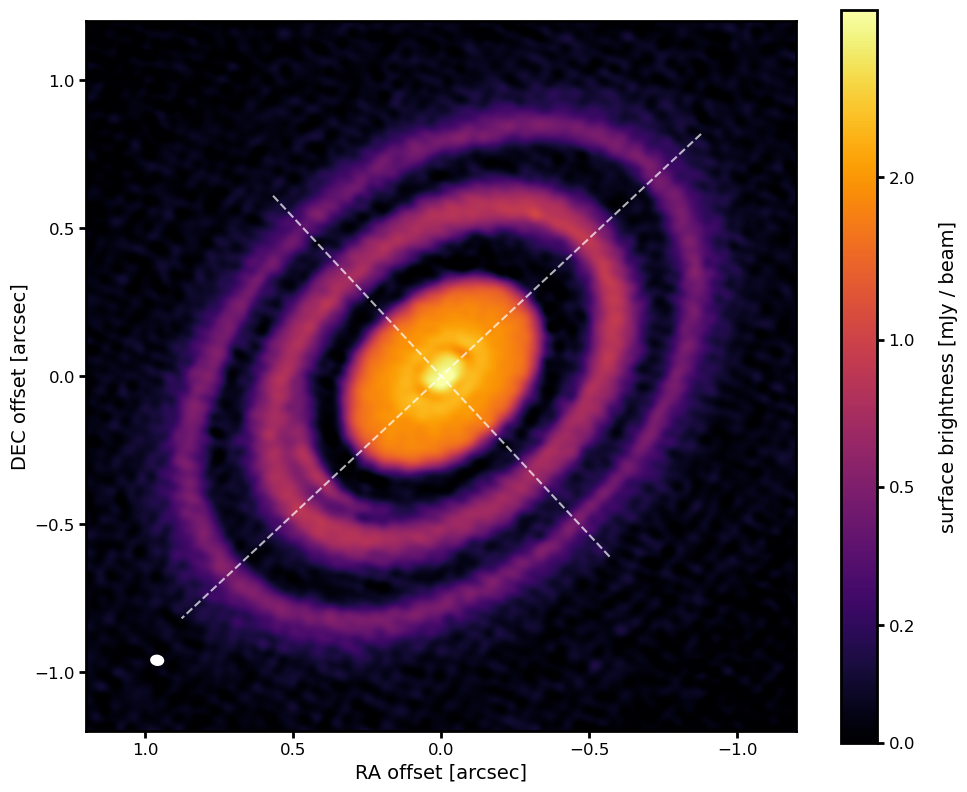

In [44]:
# image setups
im_bounds = (RAo_shift.max(), RAo_shift.min(), DECo_shift.min(), DECo_shift.max())
dRA_lims, dDEC_lims = [rout, -rout], [-rout, rout]

# intensity limits, and stretch
vmin, vmax = 0.0, 4.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(0.1))
#norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch(10))

# image plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')

# minor and major axes
rmaj = np.linspace(-rout, rout, 2)
ax.plot(rmaj * np.sin(PAr), rmaj * np.cos(PAr), '--w', alpha=0.7)
ax.plot(rmaj * np.cos(inclr) * np.sin(PAr - 0.5*np.pi), 
        rmaj * np.cos(inclr) * np.cos(PAr - 0.5*np.pi), '--w', alpha=0.7)

# limits, labeling
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=90, labelpad=17)

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), 
                beam_maj, beam_min, angle=90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)
fig.tight_layout()
plt.savefig("hd163296.png") 
plt.show()

## Ahora continua con los siguientes pasos para completar el trabajo (deproyeccion, conversión a coordenadas polares, perfil radial, etc). 